In [1]:
import os, sys
# insert parent directory at beginning of python search path
from pathlib import Path
current_path = os.getcwd()
parent_path = str(Path(current_path).parent)
sys.path.append(parent_path)

import numpy as np
from scipy.integrate import solve_ivp
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

from src.hybrid_extended_kalman_filter import HybridExtendedKalmanFilter
from src.utils import rk4, atleast_col_vector

ModuleNotFoundError: No module named 'estimators'

In [7]:
# System dynamics function
def f(x, u, w, t, params):
    assert x.shape == (3, 1)
    assert w.shape == (3, 1)

    rho0 = params['rho0']
    k = params['k']
    g = params['g']

    x = x.flatten()
    w = w.flatten()

    xdot1 = x[1] + w[0]
    xdot2 = rho0 * np.exp(-x[0]/k) * x[1]**2 / 2 * x[2] - g + w[1]
    xdot3 = w[2]

    xdot = np.array([xdot1, xdot2, xdot3]).reshape(3,1)
    assert xdot.shape == (3, 1)
    return xdot

# Measurement function
def h(x, v, t, params):
    assert x.shape == (3, 1)
    return x[0] + v[0]

# Jacobian of the system dynamics function with respect to state
def Afunc(x, u, t, params):
    assert x.shape == (3, 1)
    x = x.flatten()
     
    rho0 = params['rho0']
    k = params['k']
    g = params['g']

    A21 = -rho0 * np.exp(-x[0]/k) * x[1]**2 / 2 / k * x[2]
    A22 = rho0 * np.exp(-x[0]/k) * x[1] * x[2]
    A23 = rho0 * np.exp(-x[0]/k) * x[1]**2 / 2

    return np.array([[0, 1, 0],
                     [A21, A22, A23],
                     [0, 0, 0]])

# Jacobian of the measurement function with respect to state
def Hfunc(x, u, t, params):
    return np.array([[1, 0, 0]])

# Jacobian of the process noise function with respect to state
def Lfunc(x, u, t, params):
    return np.eye(3)

# Jacobian of the measurement noise function with respect to state
def Mfunc(x, u, t, params):
    return np.atleast_2d(1)

In [8]:
# Initial conditions
x0 = np.array([100000, -6000, 1/2000]).reshape(3, 1)
xhat0 = np.array([101000, -6100, 1/2500]).reshape(3, 1)
P0 = np.array([[500, 0, 0], [0, 20000, 0], [0, 0, 1/250000]])
R = np.atleast_2d(100)
Q = np.eye(3) * 1e-9
u = np.atleast_2d(0)

process_noise_pd = multivariate_normal([0, 0, 0], Q)
meas_noise_pd = multivariate_normal(0, R)

# Simulation time parameters
tstart = 0
tf = 16
dt = 0.004
tspan = np.arange(tstart, tf + dt, dt)

# Simulation parameters
params = {'rho0': 0.0034, 'g': 32.2, 'k': 22000, 'dt': dt}

# Create Hybrid-EKF object
ekf = HybridExtendedKalmanFilter(f, h, Q, R, x0, P0, tstart, Afunc, Lfunc, Hfunc, Mfunc)


In [9]:
# simulate
xdim=  x0.shape[0]
tdim = tspan.shape[0]
dStore = {'x': np.zeros((xdim,tdim)), 'xhat': np.zeros((xdim,tdim)), 'P': P0}
x = x0
for i, t in enumerate(tspan):   
    # Simulate the system
    w = process_noise_pd.rvs().reshape((3, 1))
    simfunc = lambda t, x: f(x, u, w, t, params)
    x = rk4(simfunc, t, params['dt'], x)

    # Simulate the measurement
    v = meas_noise_pd.rvs().reshape(1)
    z = h(x, v, t, params)
    z = atleast_col_vector(z)
    
    # Prediction step of Kalman filter
    ekf.predict(u, t, params)
    
    # Update step of Kalman filter
    ekf.update(z, u, t, params)
    
    # Store estimate
    dStore['x'][:,i] = x.flatten()
    dStore['xhat'][:,i] = ekf.x_hat.flatten()

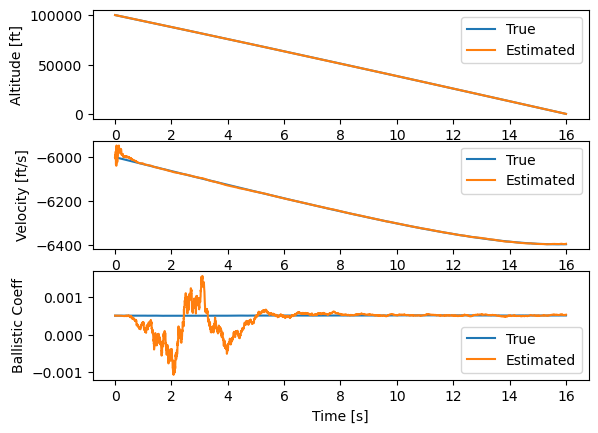

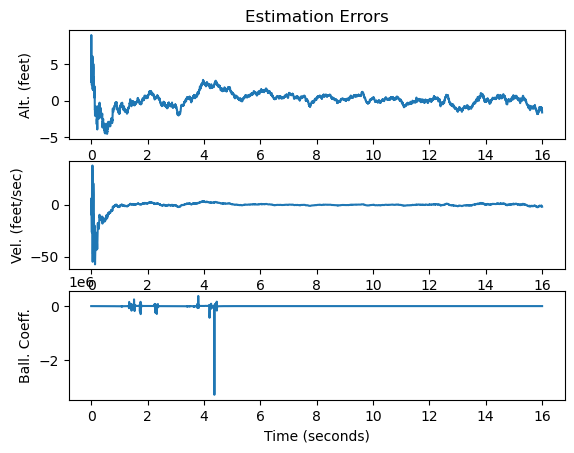

In [10]:
# Plot estimates
import matplotlib.pyplot as plt

plt.figure()
plt.subplot(3, 1, 1)
plt.plot(tspan, dStore['x'][0, :], label='True')
plt.plot(tspan, dStore['xhat'][0, :], label='Estimated')
plt.ylabel("Altitude [ft]")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(tspan, dStore['x'][1, :], label='True')
plt.plot(tspan, dStore['xhat'][1, :], label='Estimated')
plt.ylabel("Velocity [ft/s]")
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(tspan, dStore['x'][2, :], label='True')
plt.plot(tspan, dStore['xhat'][2, :], label='Estimated')
plt.ylabel("Ballistic Coeff")
plt.xlabel("Time [s]")
plt.legend()

# Plot estimation errors
plt.figure()
plt.subplot(3, 1, 1)
plt.plot(tspan, dStore['x'][0, :] - dStore['xhat'][0, :])
plt.ylabel('Alt. (feet)')
plt.title('Estimation Errors')

plt.subplot(3, 1, 2)
plt.plot(tspan, dStore['x'][1, :] - dStore['xhat'][1, :])
plt.ylabel('Vel. (feet/sec)')

plt.subplot(3, 1, 3)
plt.plot(tspan, 1/dStore['x'][2, :] - 1/dStore['xhat'][2, :])
plt.xlabel('Time (seconds)')
plt.ylabel('Ball. Coeff.')

plt.show()
